# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [780]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)
library(epitools)
library(boot)
library(pROC)

library(glmnet)
library(pls)

In [806]:
### Plotting base_theme
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

### Load data and take quick peek at select "pressors"  (e.g. vent and central line)

In [2]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [3]:
dim(pressors_df)

[1] 227645     11

In [4]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [5]:
pressors_df %>%
    filter(pressor == "ventdurations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
189130,ventdurations,0,91.00000,2199-08-07 13:00:00,200003,NA,ventdurations,2199-08-03 18:00:00,NA,1
189131,ventdurations,1,14.83333,2159-09-04 03:50:00,200006,NA,ventdurations,2159-09-03 13:00:00,NA,1
189132,ventdurations,2,15.83333,2189-12-01 10:00:00,200009,NA,ventdurations,2189-11-30 18:10:00,NA,1
189133,ventdurations,3,3.00000,2188-08-06 04:00:00,200011,NA,ventdurations,2188-08-06 01:00:00,NA,1
189134,ventdurations,4,18.75000,2105-02-17 18:00:00,200014,NA,ventdurations,2105-02-16 23:15:00,NA,1
189135,ventdurations,5,83.00000,2138-03-21 09:00:00,200017,NA,ventdurations,2138-03-17 22:00:00,NA,1


### Available pressor (and other infusions) choices
- Make choices
- Quick check of dataset balancing

In [6]:
unique(pressors_df$pressor)

[1] adenosinedurations      arterial_line_durations central_line_durations 
 [4] crrtdurations           dobutaminedurations     dopaminedurations      
 [7] epinephrinedurations    isupreldurations        milrinonedurations     
[10] norepinephrinedurations phenylephrinedurations  vasopressindurations   
[13] vasopressordurations    ventdurations          
14 Levels: adenosinedurations ... ventdurations

In [7]:
pressor_choices <- c("norepinephrinedurations", "dopaminedurations", "phenylephrinedurations")

In [826]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine")

In [835]:
FANCY_PRESSOR_DICT <- c(
'dopaminedurations' = 'Dopamine',
'norepinephrinedurations' = 'Norepinephrine',  
'phenylephrinedurations' = 'Phenylephrine'
)

In [781]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures"

In [158]:
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(MORETHAN24HOURS = duration_hours > 24) %>%
    group_by(MORETHAN24HOURS, pressor) %>% 
    summarize(COUNT = n())

MORETHAN24HOURS,pressor,COUNT
<lgl>,<fct>,<int>
FALSE,dopaminedurations,5422
FALSE,norepinephrinedurations,19811
FALSE,phenylephrinedurations,30430
TRUE,dopaminedurations,1102
TRUE,norepinephrinedurations,3377
TRUE,phenylephrinedurations,2711


### Histograms of pressor durations for all 3 pressors of interest

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1254 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1254 rows containing non-finite values (stat_density).”

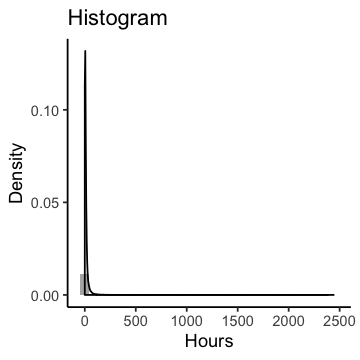

In [784]:
options(repr.plot.width=3, repr.plot.height=3)
p <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()
plot(p)

### Figure X. all pressors

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


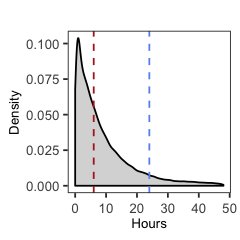

In [846]:
options(repr.plot.width=2, repr.plot.height=2)
p <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    filter(DIFF < 48) %>%
    ggplot(aes(x=DIFF)) +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill = "gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        base_theme() +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="cornflowerblue")
plot(p)

In [865]:
# pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
# plot(p)
# dev.off()

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


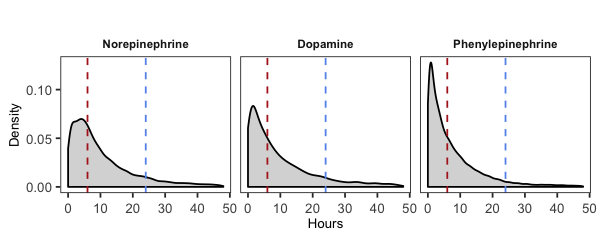

In [848]:
options(repr.plot.width=5, repr.plot.height=2)
p <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    rowwise() %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    filter(DIFF < 48) %>%
    ggplot(aes(x=DIFF)) +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill = "gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        base_theme() +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="cornflowerblue") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [866]:
# pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 5, 2)
# plot(p)
# dev.off()

### Join with icustay metadata (pressors_df + lengthstay_df -> input_df)

In [9]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [10]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [11]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Filters

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [12]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24
input_list <- list()
for(pressor_choice in pressor_choices){
    input_list[[pressor_choice]] <- input_df %>%
        filter(pressor == pressor_choice) %>%
        group_by(icustay_id) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(icustay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)
    cat(pressor_choice, '\n')
}

norepinephrinedurations 
dopaminedurations 
phenylephrinedurations 


In [13]:
input_df <- bind_rows(input_list, .id="pressor_choice")

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [14]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               )

In [15]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [16]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [17]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS, pressor) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,pressor,COUNT
<lgl>,<lgl>,<lgl>,<fct>,<int>
FALSE,FALSE,FALSE,dopaminedurations,740
FALSE,FALSE,FALSE,norepinephrinedurations,2340
FALSE,FALSE,FALSE,phenylephrinedurations,2994
FALSE,FALSE,TRUE,dopaminedurations,838
FALSE,FALSE,TRUE,norepinephrinedurations,6513
FALSE,FALSE,TRUE,phenylephrinedurations,5674
FALSE,TRUE,FALSE,dopaminedurations,2124
FALSE,TRUE,FALSE,norepinephrinedurations,3782
FALSE,TRUE,FALSE,phenylephrinedurations,11821


In [18]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS, pressor) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,pressor,COUNT
<lgl>,<lgl>,<lgl>,<fct>,<int>
FALSE,FALSE,FALSE,dopaminedurations,571
FALSE,FALSE,FALSE,norepinephrinedurations,1592
FALSE,FALSE,FALSE,phenylephrinedurations,1859
FALSE,FALSE,TRUE,dopaminedurations,302
FALSE,FALSE,TRUE,norepinephrinedurations,1482
FALSE,FALSE,TRUE,phenylephrinedurations,1097
FALSE,TRUE,FALSE,dopaminedurations,1694
FALSE,TRUE,FALSE,norepinephrinedurations,2611
FALSE,TRUE,FALSE,phenylephrinedurations,6812


Warning message:
“Removed 2521 rows containing non-finite values (stat_density).”

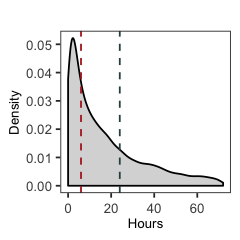

In [973]:
options(repr.plot.width=2, repr.plot.height=2)
p <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    summarize(duration_hours = sum(duration_hours)) %>%
    ggplot(aes(x=duration_hours)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 72) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [974]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 2521 rows containing non-finite values (stat_density).”

pdf 
  2

Warning message:
“Removed 2521 rows containing non-finite values (stat_density).”

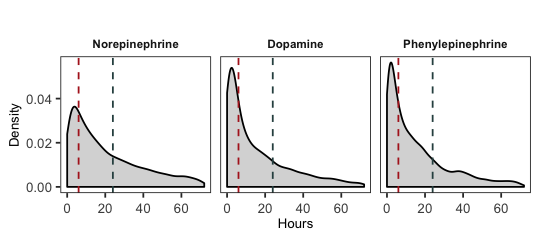

In [986]:
options(repr.plot.width=4.5, repr.plot.height=2)
p <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    summarize(duration_hours = sum(duration_hours)) %>%
    rowwise() %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration_hours)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 72) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [987]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 4.5, 2)
plot(p)
dev.off()

Warning message:
“Removed 2521 rows containing non-finite values (stat_density).”

pdf 
  2

### Introduce other predictor values for each course (like RACE, Diagnosis type) -> nonvitals_predictor_df

In [19]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [20]:
sepsis_regex <- c('SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(sepsis_regex, function(x) grepl(x, diagnosis)))){return("SEPSIS")}
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [21]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [22]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [23]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [24]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- pressors_df %>%
    filter(pressor == "central_line_durations") 

In [25]:
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, 
           age_cohort = as.numeric(round(age, digits = -1))) %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis))

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)
- Also quantify some unusual cases of death documentation

In [1088]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,40
TRUE,6422
NA,55070


In [1089]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [1090]:
#Examples (admitted after death)
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,dod,dod_hosp,dod_ssn,expire_flag,intub,cvc,age,age_cohort,simple_race,simple_diagnosis
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<fct>,<fct>,<fct>,<int>,<lgl>,<lgl>,<drtn>,<dbl>,<chr>,<chr>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,2153-10-12,2153-10-12,2153-10-12,1,FALSE,FALSE,65.12757082 weeks,70,WHITE,OTHER DIAGNOSIS
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,2137-09-02,2137-09-02,,1,TRUE,FALSE,0.00167654 weeks,0,WHITE,OTHER DIAGNOSIS
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,2189-01-02,2189-01-02,2189-01-02,1,TRUE,FALSE,81.36049404 weeks,80,WHITE,OTHER DIAGNOSIS
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,2197-07-31,2197-07-31,2197-07-31,1,FALSE,FALSE,70.88679654 weeks,70,OTHER,OTHER DIAGNOSIS
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,2108-09-25,2108-09-25,2108-09-25,1,TRUE,FALSE,82.42418356 weeks,80,WHITE,OTHER DIAGNOSIS


In [1091]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,3416
TRUE,658
NA,13640


### Test out some mortality filters

In [1092]:
### if I do not ignore for unusual cases (pressors after death)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,16598
TRUE,3584
NA,42671


In [1093]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,19985
TRUE,197
NA,42671


### Create filters for mortality: input_df -> input_death_df

In [531]:
# # ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# # do not remove unusual cases
# input_death_df <- input_df %>%
#     ungroup() %>%
#     left_join(nonvitals_predictor_df, by = "icustay_id") %>%
#     group_by(icustay_id, continuous_course, pressor) %>%
#     mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
#     mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [26]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage): : input_death_df -> input_death_df

In [1154]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,3696
FALSE,FALSE,FALSE,FALSE,TRUE,6
FALSE,FALSE,FALSE,TRUE,FALSE,2677
FALSE,FALSE,FALSE,TRUE,TRUE,18
FALSE,FALSE,TRUE,FALSE,FALSE,21
FALSE,FALSE,TRUE,TRUE,FALSE,17
FALSE,TRUE,FALSE,FALSE,FALSE,10778
FALSE,TRUE,FALSE,FALSE,TRUE,90
FALSE,TRUE,FALSE,TRUE,FALSE,4785


In [27]:
input_death_df <- input_death_df %>%
    filter(first_careunit != "NICU")

### Use filters, clean predictors: input_death_df -> output_df

In [990]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id, pressor) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

In [991]:
# collapse so each row is a course_id
output_df <- output_df %>%
    group_by(course_id, pressor) %>%
    summarize(
            STATUS = unique(STATUS)[1], 
            MORETHAN24HOURS = unique(MORETHAN24HOURS)[1], 
            simple_diagnosis = unique(simple_diagnosis)[1], 
            simple_race = unique(simple_race)[1], 
            age = unique(age)[1], 
            age_cohort = unique(age_cohort)[1], 
            cvc = unique(cvc)[1],
            intub = unique(intub)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            icustay_id = unique(icustay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime)
    ) %>% 
    mutate(duration = difftime(endtime, 
                       starttime, units="hours"))

# Analysis

### For text, description of meta-data

In [895]:
# minimum age
min(output_df$age, na.rm=TRUE)

[1] 15.15073

In [381]:
dim(output_df)

[1] 15853    15

In [377]:
output_df %>%
    group_by(STATUS) %>%
    summarize(COUNT = n())

STATUS,COUNT
<chr>,<int>
LESSTHAN24HOURS,5598
LESSTHAN6HOURS,5407
MORETHAN24HOURS,4848


In [378]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = n())

STATUS,pressor,COUNT
<chr>,<fct>,<int>
LESSTHAN24HOURS,dopaminedurations,697
LESSTHAN24HOURS,norepinephrinedurations,1548
LESSTHAN24HOURS,phenylephrinedurations,3353
LESSTHAN6HOURS,dopaminedurations,903
LESSTHAN6HOURS,norepinephrinedurations,1053
LESSTHAN6HOURS,phenylephrinedurations,3451
MORETHAN24HOURS,dopaminedurations,623
MORETHAN24HOURS,norepinephrinedurations,1846
MORETHAN24HOURS,phenylephrinedurations,2379


In [379]:
output_df %>%
    group_by(STATUS == "MORETHAN24HOURS") %>%
    summarize(COUNT = n())

"STATUS == ""MORETHAN24HOURS""",COUNT
<lgl>,<int>
FALSE,11005
TRUE,4848


In [380]:
output_df %>%
    group_by(STATUS == "MORETHAN24HOURS", pressor) %>%
    summarize(COUNT = n()) %>% arrange(pressor)

"STATUS == ""MORETHAN24HOURS""",pressor,COUNT
<lgl>,<fct>,<int>
FALSE,dopaminedurations,1600
TRUE,dopaminedurations,623
FALSE,norepinephrinedurations,2601
TRUE,norepinephrinedurations,1846
FALSE,phenylephrinedurations,6804
TRUE,phenylephrinedurations,2379


### Figure X. CVC associated with longer pressor courses

In [1032]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [1053]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 1354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1354 rows containing non-finite values (stat_summary).”

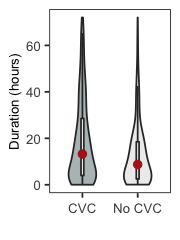

In [1067]:
options(repr.plot.width=1.5, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [1068]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 1.5,2)
plot(p)
dev.off()

Warning message:
“Removed 1354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1354 rows containing non-finite values (stat_summary).”

pdf 
  2

In [1066]:
for(presor_choice in pressor_choices){
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 


Warning message:
“Removed 1354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1354 rows containing non-finite values (stat_summary).”

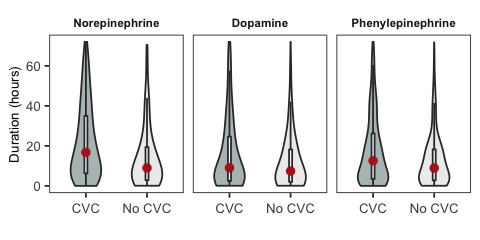

In [1070]:
options(repr.plot.width=4, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [1071]:
pdf(file.path(PLOT_DIR, "cvcduration_eachpressor.pdf"), 4,2)
plot(p)
dev.off()

Warning message:
“Removed 1354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1354 rows containing non-finite values (stat_summary).”

pdf 
  2

### Table 1 (RR Analysis)

In [870]:
t1_df <- output_df %>% 
    group_by(STATUS) %>%
    summarize(COUNT = n(), 
              AGE_MEAN = as.numeric(mean(age, na.rm=TRUE)), AGE_SD = sd(age, na.rm=TRUE),
              FEMALE_SUM = sum(gender == 'F'),
              FEMALE_FRAC = sum(gender == 'F')/n(),
              WHITE_SUM = sum(simple_race == 'WHITE'),
              WHITE_FRAC = sum(simple_race == 'WHITE')/n(),
              BLACK_SUM = sum(simple_race == 'BLACK'),
              BLACK_FRAC = sum(simple_race == 'BLACK')/n(),
              HISPANIC_SUM = sum(simple_race == 'HISPANIC'),
              HISPANIC_FRAC = sum(simple_race == 'HISPANIC')/n(),
              ASIAN_SUM = sum(simple_race == 'ASIAN'),
              ASIAN_FRAC = sum(simple_race == 'ASIAN')/n(),
              MICU_SUM = sum(first_careunit == 'MICU'),
              MICU_FRAC = sum(first_careunit == 'MICU')/n(),
              SICU_SUM = sum(first_careunit == 'SICU'),
              SICU_FRAC = sum(first_careunit == 'SICU')/n(),
              CCU_SUM = sum(first_careunit == 'CCU'),
              CCU_FRAC = sum(first_careunit == 'CCU')/n(),
              TSICU_SUM = sum(first_careunit == 'TSICU'),
              TSICU_FRAC = sum(first_careunit == 'TSICU')/n(),
              CSRU_SUM = sum(first_careunit == 'CSRU'),
              CSRU_FRAC = sum(first_careunit == 'CSRU')/n(),
              SEPSIS_SUM = sum(simple_diagnosis == "SEPSIS"),
              SEPSIS_FRAC = sum(simple_diagnosis == "SEPSIS")/n(),
              INFX_SUM = sum(simple_diagnosis == "INFECTION"),
              INFX_FRAC = sum(simple_diagnosis == "INFECTION")/n(),
              CARDIAC_SUM = sum(simple_diagnosis == "CARDIAC"),
              CARDIAC_FRAC = sum(simple_diagnosis == "CARDIAC")/n(),
              CVC_SUM = sum(cvc == "TRUE", na.rm=TRUE),
              CVC_FRAC = sum(cvc == "TRUE", na.rm=TRUE)/n(),
              INTUB_SUM = sum(intub == "TRUE", na.rm=TRUE),
              INTUB_FRAC = sum(intub == "TRUE", na.rm=TRUE)/n()
             ) %>% t()

In [871]:
colnames(t1_df) <- t1_df[1,]

In [872]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
COUNT,5598,5407,4848
AGE_MEAN,65.71429,66.29365,65.21121
AGE_SD,14.33112,14.47993,14.48098
FEMALE_SUM,2133,2258,2002
FEMALE_FRAC,0.3810289,0.4176068,0.4129538
WHITE_SUM,4008,3889,3439
WHITE_FRAC,0.7159700,0.7192528,0.7093647
BLACK_SUM,323,364,319
BLACK_FRAC,0.05769918,0.06732014,0.06580033


In [873]:
t1_df %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

### Supplement 1-3

In [874]:
s1_3_df <- output_df %>% 
    group_by(STATUS, pressor) %>%
    summarize(COUNT = n(), 
              AGE_MEAN = as.numeric(mean(age, na.rm=TRUE)), AGE_SD = sd(age, na.rm=TRUE),
              FEMALE_SUM = sum(gender == 'F'),
              FEMALE_FRAC = sum(gender == 'F')/n(),
              WHITE_SUM = sum(simple_race == 'WHITE'),
              WHITE_FRAC = sum(simple_race == 'WHITE')/n(),
              BLACK_SUM = sum(simple_race == 'BLACK'),
              BLACK_FRAC = sum(simple_race == 'BLACK')/n(),
              HISPANIC_SUM = sum(simple_race == 'HISPANIC'),
              HISPANIC_FRAC = sum(simple_race == 'HISPANIC')/n(),
              ASIAN_SUM = sum(simple_race == 'ASIAN'),
              ASIAN_FRAC = sum(simple_race == 'ASIAN')/n(),
              MICU_SUM = sum(first_careunit == 'MICU'),
              MICU_FRAC = sum(first_careunit == 'MICU')/n(),
              SICU_SUM = sum(first_careunit == 'SICU'),
              SICU_FRAC = sum(first_careunit == 'SICU')/n(),
              CCU_SUM = sum(first_careunit == 'CCU'),
              CCU_FRAC = sum(first_careunit == 'CCU')/n(),
              TSICU_SUM = sum(first_careunit == 'TSICU'),
              TSICU_FRAC = sum(first_careunit == 'TSICU')/n(),
              CSRU_SUM = sum(first_careunit == 'CSRU'),
              CSRU_FRAC = sum(first_careunit == 'CSRU')/n(),
              SEPSIS_SUM = sum(simple_diagnosis == "SEPSIS"),
              SEPSIS_FRAC = sum(simple_diagnosis == "SEPSIS")/n(),
              INFX_SUM = sum(simple_diagnosis == "INFECTION"),
              INFX_FRAC = sum(simple_diagnosis == "INFECTION")/n(),
              CARDIAC_SUM = sum(simple_diagnosis == "CARDIAC"),
              CARDIAC_FRAC = sum(simple_diagnosis == "CARDIAC")/n(),
              CVC_SUM = sum(cvc == "TRUE", na.rm=TRUE),
              CVC_FRAC = sum(cvc == "TRUE", na.rm=TRUE)/n(),
              INTUB_SUM = sum(intub == "TRUE", na.rm=TRUE),
              INTUB_FRAC = sum(intub == "TRUE", na.rm=TRUE)/n()
             ) %>% t()

In [875]:
colnames(s1_3_df) <- s1_3_df[1,]

In [876]:
s1_3_df

,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MORETHAN24HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MORETHAN24HOURS,MORETHAN24HOURS
pressor,dopaminedurations,norepinephrinedurations,phenylephrinedurations,dopaminedurations,norepinephrinedurations,phenylephrinedurations,dopaminedurations,norepinephrinedurations,phenylephrinedurations
COUNT,697,1548,3353,903,1053,3451,623,1846,2379
AGE_MEAN,67.92663,66.15543,65.09732,67.78580,66.04628,65.99762,69.47552,64.32555,64.82908
AGE_SD,14.44968,14.74278,14.07711,14.11339,15.36275,14.28056,13.03657,15.07623,14.18046
FEMALE_SUM,335,659,1139,431,471,1356,257,803,942
FEMALE_FRAC,0.4806313,0.4257106,0.3396958,0.4772979,0.4472934,0.3929296,0.4125201,0.4349946,0.3959647
WHITE_SUM,491,1075,2442,623,746,2520,422,1328,1689
WHITE_FRAC,0.7044476,0.6944444,0.7283030,0.6899225,0.7084520,0.7302231,0.6773676,0.7193933,0.7099622
BLACK_SUM,56,128,139,77,106,181,49,166,104


In [877]:
s1_3_df %>% write.csv(file.path(PLOT_DIR, "response_eachpressor_demographics.csv"))

# Categorical Predictors

In [878]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(MORETHAN24HOURS, gender) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(MORETHAN24HOURS, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, MORETHAN24HOURS) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(MORETHAN24HOURS, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(MORETHAN24HOURS, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, MORETHAN24HOURS) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(MORETHAN24HOURS, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, MORETHAN24HOURS) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, MORETHAN24HOURS) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(MORETHAN24HOURS, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


    # careunit
    careunit_df <- df %>%
        group_by(MORETHAN24HOURS, first_careunit) %>%
        summarize(COUNT = n())

    rr_list <- list()
    for(cu in unique(careunit_df$first_careunit)){
       output <- careunit_df%>%
            mutate(CU_BOOL = first_careunit == cu) %>%
            group_by(CU_BOOL, MORETHAN24HOURS) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(MORETHAN24HOURS, COUNT) %>%
            tibble::column_to_rownames("CU_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[cu]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(MORETHAN24HOURS, intub) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

    # cvc
    output <- df %>%
        group_by(MORETHAN24HOURS, cvc) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("cvc") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['CVC_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}


# Table 1 (RR significance)

In [888]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9606925,0.9160746,1.0074835,MALE,1.022581e-01,FALSE
AGE_RR,1.0222441,0.8183056,1.2770083,20,8.682009e-01,FALSE
AGE_RR,1.1039998,0.9449763,1.2897843,30,2.211771e-01,FALSE
AGE_RR,1.0585757,0.9503296,1.1791513,40,3.041662e-01,FALSE
AGE_RR,1.0639489,0.9935335,1.1393549,50,8.162781e-02,FALSE
AGE_RR,1.0223690,0.9657030,1.0823600,60,4.469965e-01,FALSE
AGE_RR,0.9690306,0.9171697,1.0238239,70,2.631335e-01,FALSE
AGE_RR,0.9897123,0.9360450,1.0464565,80,7.287582e-01,FALSE
AGE_RR,0.8322938,0.7367126,0.9402758,90,2.108572e-03,TRUE


In [889]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

### Supplement 1-3

In [890]:
pressor_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(pressor == pressor_choice) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [949]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [950]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
norepinephrinedurations,MALE_RR,0.9987007,0.9308398,1.0715088,M,9.755196e-01,FALSE
norepinephrinedurations,AGE_RR,1.0694181,0.7971248,1.4347252,20,6.839022e-01,FALSE
norepinephrinedurations,AGE_RR,1.1233746,0.9165693,1.3768413,30,2.813284e-01,FALSE
norepinephrinedurations,AGE_RR,1.0942546,0.9431415,1.2695795,40,2.634795e-01,FALSE
norepinephrinedurations,AGE_RR,1.1130040,1.0111660,1.2250985,50,3.466969e-02,TRUE
norepinephrinedurations,AGE_RR,1.0310668,0.9466765,1.1229801,60,4.943105e-01,FALSE
norepinephrinedurations,AGE_RR,1.0196759,0.9392326,1.1070091,70,6.629963e-01,FALSE
norepinephrinedurations,AGE_RR,0.8889863,0.8148738,0.9698394,80,7.352456e-03,TRUE
norepinephrinedurations,AGE_RR,0.8222276,0.6891269,0.9810359,90,2.241649e-02,TRUE


In [951]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

# Figure 1 Plotting RR

In [969]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [979]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'SEPSIS' = "Sepsis Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis",
'CCU' = 'CCU',
'CSRU' = 'CSRU',
'MICU' = 'MICU',
'SICU' = 'SICU',
'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”

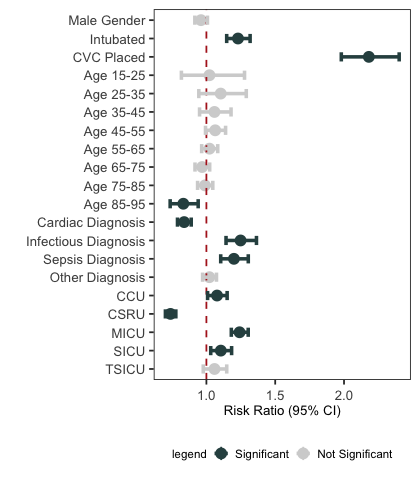

In [980]:
options(repr.plot.width=3.5, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [981]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.5,4)
plot(p)
dev.off()

pdf 
  2

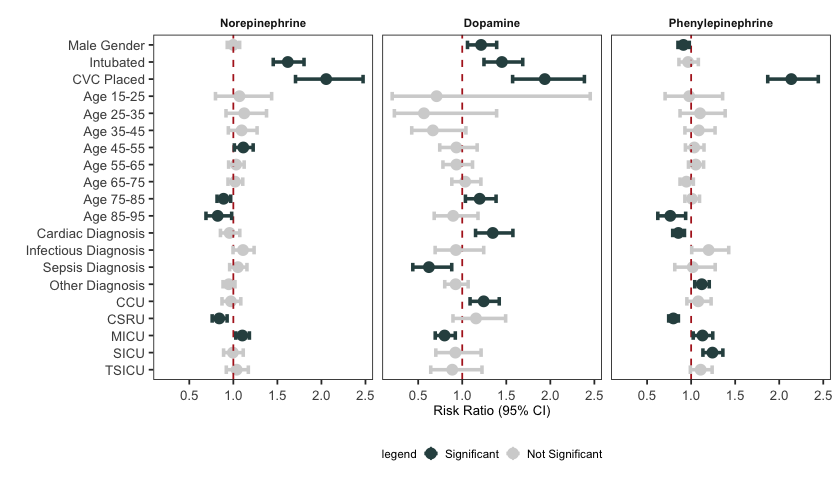

In [982]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [983]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

### Pre-processing (30 minutes): read in vitals_df, join with output_df of courses and compute mean vitals information each hour -> results_df

In [31]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [32]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, STATUS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [774]:
intervals <- 1:10

In [775]:
results_list <- list()

In [776]:
# takes 30 mins to run overall
for(interval in intervals){
    # 2 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, STATUS, course_id, pressor) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [777]:
results_df <- bind_rows(results_list) 

In [778]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -course_id, -pressor, -MORETHAN24HOURS, -INTERVAL, -STATUS)

In [779]:
head(melt_results_df)

MORETHAN24HOURS,STATUS,course_id,pressor,INTERVAL,ID,VALUE
<lgl>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
FALSE,LESSTHAN24HOURS,"200028,0",norepinephrinedurations,1,mean_heartrate,70.00000
FALSE,LESSTHAN24HOURS,"200030,0",norepinephrinedurations,1,mean_heartrate,84.33333
FALSE,LESSTHAN24HOURS,"200033,0",phenylephrinedurations,1,mean_heartrate,118.00000
FALSE,LESSTHAN24HOURS,"200065,0",norepinephrinedurations,1,mean_heartrate,121.50000
FALSE,LESSTHAN24HOURS,"200075,0",norepinephrinedurations,1,mean_heartrate,83.50000
FALSE,LESSTHAN24HOURS,"200078,0",phenylephrinedurations,1,mean_heartrate,100.00000



### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [39]:
computeANCOVA <- function(df) {
    vitals_result_list <- list()
    for(vital in unique(melt_results_df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        test <- summary(aov(VALUE ~ MORETHAN24HOURS*INTERVAL, data = totest))[[1]]

        vitals_result_list[[vital]] <- data.frame(MORETHAN24HOURS = test["MORETHAN24HOURS ", "Pr(>F)"], 
                                                 INTERACTION = test["MORETHAN24HOURS:INTERVAL", "Pr(>F)"])
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
}

# Table 2 (Wilcox and ANCOVA Vitals)

In [155]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

### Table 2. mean and standard deviation of vitals  for different time status

In [172]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(MEAN = mean(VALUE)) %>%
    spread(STATUS, MEAN)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,55.22917,56.44289,55.32072
mean_glucose,148.90861,147.99218,150.25696
mean_heartrate,89.10626,87.34313,91.08273
mean_meanbp,71.51656,73.01946,71.07429
mean_resprate,17.46904,17.30728,18.46853
mean_spo2,97.48808,97.44695,97.11629
mean_sysbp,105.49908,108.54064,104.49804
mean_tempc,36.43361,36.31429,36.45664
median_diasbp,55.09159,56.20398,55.13805


In [173]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(SD = sd(VALUE)) %>%
    spread(STATUS, SD)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,12.754692,13.747756,13.377874
mean_glucose,64.971211,62.926642,69.631472
mean_heartrate,19.471682,19.563885,20.624659
mean_meanbp,14.495720,15.430592,15.698844
mean_resprate,5.690783,5.654486,6.015169
mean_spo2,4.964570,5.063171,4.751042
mean_sysbp,18.818804,20.928887,20.454842
mean_tempc,1.074207,1.189952,1.168407
median_diasbp,12.934652,13.923542,13.536256


In [178]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(MEAN = mean(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, MEAN) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,dopaminedurations,52.51638,52.91710,52.49037
mean_glucose,dopaminedurations,198.98734,182.86860,197.37073
mean_heartrate,dopaminedurations,85.27362,89.25072,82.46981
mean_meanbp,dopaminedurations,69.03345,68.07169,68.43626
mean_resprate,dopaminedurations,18.91443,20.06488,19.24126
mean_spo2,dopaminedurations,96.13067,95.54895,95.80932
mean_sysbp,dopaminedurations,104.28148,102.04466,103.10880
mean_tempc,dopaminedurations,36.41958,36.35060,36.25883
median_diasbp,dopaminedurations,52.28919,52.58877,52.10127


In [179]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(SD = sd(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, SD) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<fct>,<dbl>,<dbl>,<dbl>
mean_diasbp,dopaminedurations,13.509050,15.819260,13.927454
mean_glucose,dopaminedurations,103.469725,102.119984,111.857982
mean_heartrate,dopaminedurations,21.427894,23.278467,20.609729
mean_meanbp,dopaminedurations,15.322372,16.746069,14.538947
mean_resprate,dopaminedurations,5.155841,5.663237,5.588813
mean_spo2,dopaminedurations,5.204071,6.154325,5.734098
mean_sysbp,dopaminedurations,21.107817,21.934367,21.355673
mean_tempc,dopaminedurations,1.113871,1.313373,1.251552
median_diasbp,dopaminedurations,13.540743,16.040870,14.089353


### Wilcox for significant difference at <1 hr before start of pressors

All pressors

In [1216]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,6.138732e-02,4.060692e-03,55.82784,55.32072,0.50712280,FALSE-TRUE,TRUE
mean_glucose,3.284543e-01,8.168638e-01,148.45337,150.25696,-1.80358930,FALSE-TRUE,FALSE
mean_heartrate,4.098007e-12,1.209843e-14,88.23731,91.08273,-2.84541295,FALSE-TRUE,TRUE
mean_meanbp,1.647502e-04,4.993955e-08,72.25716,71.07429,1.18286758,FALSE-TRUE,TRUE
mean_resprate,9.060219e-21,2.637535e-23,17.38850,18.46853,-1.08002430,FALSE-TRUE,TRUE
mean_spo2,3.771532e-04,1.784907e-13,97.46784,97.11629,0.35154329,FALSE-TRUE,TRUE
mean_sysbp,1.384325e-09,8.150123e-16,106.99935,104.49804,2.50130684,FALSE-TRUE,TRUE
mean_tempc,1.641980e-02,4.810184e-02,36.37568,36.45664,-0.08096468,FALSE-TRUE,TRUE
median_diasbp,6.721541e-02,6.127488e-03,55.64028,55.13805,0.50223075,FALSE-TRUE,TRUE


Pressors by type

In [164]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    mutate(pressor = factor(pressor, levels=pressor_choices)) %>%
    group_by(ID, pressor) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05) %>%
    arrange(pressor)

ID,pressor,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,norepinephrinedurations,3.331572e-02,1.472646e-02,55.35264,54.23575,1.11688226,FALSE-TRUE,TRUE
mean_glucose,norepinephrinedurations,5.724678e-01,5.858557e-01,166.18769,163.63953,2.54815444,FALSE-TRUE,FALSE
mean_heartrate,norepinephrinedurations,4.209055e-09,3.892865e-10,91.15775,95.44150,-4.28375570,FALSE-TRUE,TRUE
mean_meanbp,norepinephrinedurations,6.390642e-04,3.120962e-05,70.09268,68.15919,1.93349593,FALSE-TRUE,TRUE
mean_resprate,norepinephrinedurations,2.237160e-07,1.198224e-07,19.17722,20.24327,-1.06605115,FALSE-TRUE,TRUE
mean_spo2,norepinephrinedurations,2.908707e-01,1.596030e-04,96.52805,96.31018,0.21787028,FALSE-TRUE,TRUE
mean_sysbp,norepinephrinedurations,2.525364e-06,5.879073e-08,104.30735,100.84525,3.46209502,FALSE-TRUE,TRUE
mean_tempc,norepinephrinedurations,2.014236e-01,2.669722e-01,36.44807,36.53375,-0.08568111,FALSE-TRUE,FALSE
median_diasbp,norepinephrinedurations,3.693948e-02,1.822012e-02,55.17304,54.06702,1.10601563,FALSE-TRUE,TRUE


### ANCOVA for significant differences summarized

Total pressors

In [1076]:
ancova_significance_df <- computeANCOVA(melt_results_df) %>% mutate(
    morethan24hours_significant = MORETHAN24HOURS < 0.05, 
    interaction_interaction = INTERACTION < 0.05) %>%
    rename(morethan24hours_pvalue = MORETHAN24HOURS, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_df

vital_sign,morethan24hours_pvalue,interaction_pvalue,morethan24hours_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,1.243038e-30,0.1132776475,TRUE,FALSE
mean_sysbp,7.346551e-44,0.0006181598,TRUE,TRUE
mean_diasbp,9.278100e-07,0.1945913337,TRUE,FALSE
mean_meanbp,2.076218e-15,0.4030909834,TRUE,FALSE
mean_resprate,2.683617e-64,0.0097918982,TRUE,TRUE
mean_tempc,1.659301e-03,0.4450229830,TRUE,FALSE
mean_spo2,2.522526e-16,0.6961708305,TRUE,FALSE
mean_glucose,1.255091e-02,0.9446338630,TRUE,FALSE
median_heartrate,6.473798e-31,0.0976214620,TRUE,FALSE


In [1077]:
ancova_significance_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance.csv"))

Pressors by type

In [1078]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(pressor == pressor_choice) %>%
        computeANCOVA() %>%
        mutate(
            morethan24hours_significant = MORETHAN24HOURS < 0.05, 
            interaction_interaction = INTERACTION < 0.05)
}

pressors_vitals_rr_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

In [1079]:
ancova_significance_eachpressor_df <- pressors_vitals_rr_df %>%
    rename(morethan24hours_pvalue = MORETHAN24HOURS, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_eachpressor_df

pressor,vital_sign,morethan24hours_pvalue,interaction_pvalue,morethan24hours_significant,interaction_interaction
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
norepinephrinedurations,mean_heartrate,1.776750e-16,0.0966926912,TRUE,FALSE
norepinephrinedurations,mean_sysbp,6.988496e-34,0.0004413466,TRUE,TRUE
norepinephrinedurations,mean_diasbp,6.919672e-07,0.1772755175,TRUE,FALSE
norepinephrinedurations,mean_meanbp,5.139855e-15,0.0570921050,TRUE,FALSE
norepinephrinedurations,mean_resprate,1.309683e-33,0.7703809526,TRUE,FALSE
norepinephrinedurations,mean_tempc,9.887433e-02,0.6052734835,FALSE,FALSE
norepinephrinedurations,mean_spo2,1.543707e-01,0.2615521256,FALSE,FALSE
norepinephrinedurations,mean_glucose,6.711331e-01,0.5167688012,FALSE,FALSE
norepinephrinedurations,median_heartrate,2.162075e-16,0.0885995356,TRUE,FALSE


In [1080]:
ancova_significance_eachpressor_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance_eachpressor.csv"))

# Figure 2 ANCOVA Plotting

In [1081]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")

Total pressors

In [1102]:
FANCY_VITAL_ORDER <- c('MAP', 'HR', 'RR', 'SpO2', 'Temperature', 'Glucose')

In [1103]:
FANCY_VITAL_DICT <- c(
    'mean_meanbp' = 'MAP', 
    'mean_heartrate' = 'HR', 
    'mean_resprate' = 'RR', 
    'mean_spo2' = 'SpO2', 
    'mean_tempc' = 'Temperature', 
    'mean_glucose' = 'Glucose')

In [1104]:
PRESSORHOURS_COLORS <- c(
">24 hrs pressors" = '#2F4F4F',
"<=24 hrs pressors" = '#D3D3D3'
)

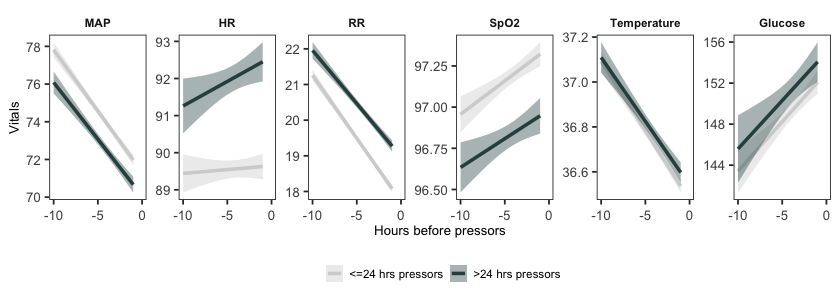

In [1109]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    rowwise() %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(MORETHAN24HOURS){">24 hrs pressors"}else{"<=24 hrs pressors"}) %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before pressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [1110]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

pdf 
  2

Pressors by type

In [1113]:
pressor_choices

[1] "norepinephrinedurations" "dopaminedurations"      
[3] "phenylephrinedurations"

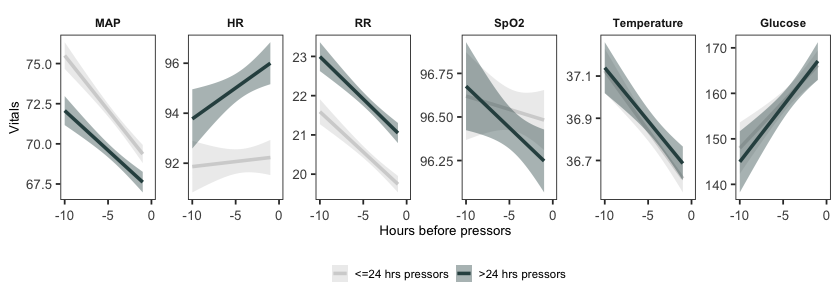

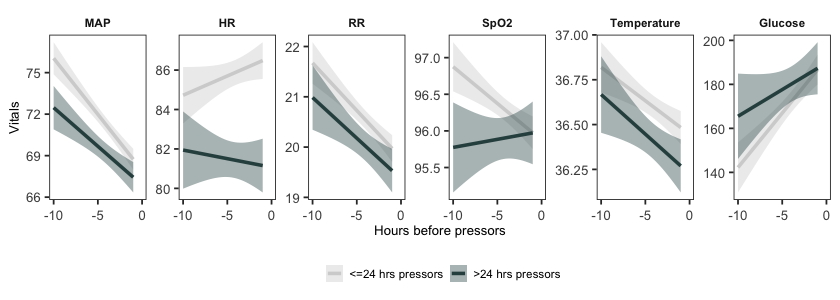

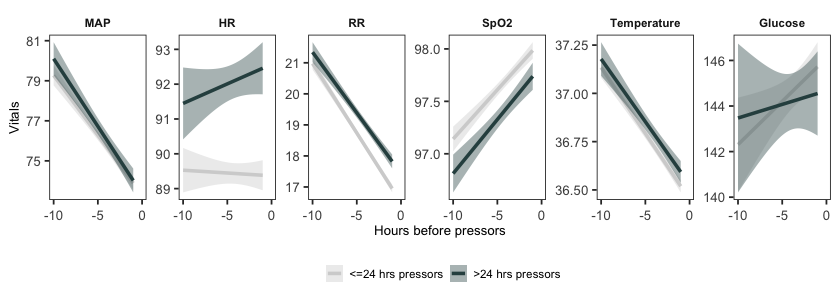

In [1115]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in pressor_choices){
    toplot <- melt_results_df %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp") %>%
        rowwise() %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(MORETHAN24HOURS){">24 hrs pressors"}else{"<=24 hrs pressors"}) 

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before pressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# LR Summary

In [1142]:
lr_summary_list <- list()

### ROC curve with CI

In [1156]:
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    theme_minimal() +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

# LR Model for Total
- Ran into problems with missing data for glucose, spo2 and tempc, hence the selection of criteria as variables

In [1171]:
model_input_df <- melt_results_df %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE, pressor) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(MORETHAN24HOURS, pressor, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id, -pressor) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(ICUSTAY, VARIABLE, VALUE, pressor, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message:
“Trying to compute distinct() for variables not found in the data:
- `ICUSTAY`
This is an error, but only a warning is raised for compatibility reasons.
The following variables will be used:
- VARIABLE
- VALUE
- pressor”

In [1172]:
# note: selection of input variables in the line below (and RESPONSE)
model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             pressor,
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

In [1173]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1174]:
dim(model_input_df)

[1] 1264   37

In [1175]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

#### Model parameter significance

In [1176]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6726  -0.9298  -0.7122   1.1866   2.2589  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      0.4592470  0.6875303   0.668 0.504155    
first_careunitCSRU              -0.7010518  0.2582362  -2.715 0.006632 ** 
first_careunitMICU              -0.3019865  0.2207068  -1.368 0.171228    
first_careunitSICU              -0.5219248  0.2455059  -2.126 0.033510 *  
first_careunitTSICU             -0.6162778  0.2654786  -2.321 0.020266 *  
intubTRUE                        0.3547462  0.2023553   1.753 0.079587 .  
simple_diagnosisINFECTION       -0.5550922  0.3115043  -1.782 0.074754 .  
simple_diagnosisOTHER DIAGNOSIS -0.4312782  0.2240158  -1.925 0.054203 .  
simple_diagnosisSEPSIS          -0.5260939  0.4119757  -1.277 0.201601    
age_cohort             

In [1177]:
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, "modelestimates.csv"))

In [1178]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


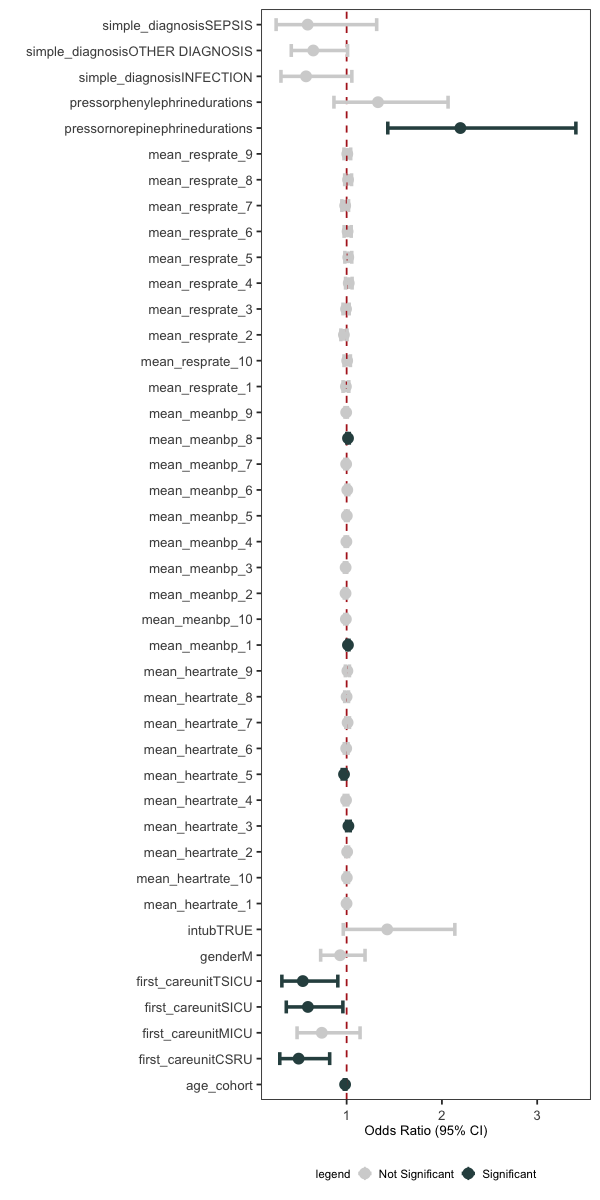

In [1179]:
options(repr.plot.height=10, repr.plot.width=5)
p <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1180]:
pdf(file.path(PLOT_DIR, paste0("modelodds.pdf")), 5,10)
plot(p)
dev.off()

pdf 
  2

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


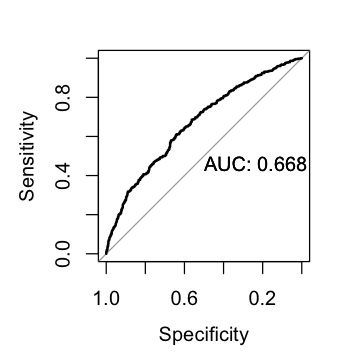

In [1181]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
plot(p_out, print.auc=TRUE)

In [1182]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))

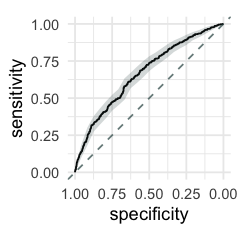

In [1183]:
options(repr.plot.width=2, repr.plot.height=2)
p <- roc_with_ci(p_out)

plot(p)

In [1184]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 2,2)
plot(p)
dev.off()

pdf 
  2

# LR model for each pressor
- Please investigate missing data
- May need to replot OR for estimates

norepinephrinedurations 


Warning message:
“attributes are not identical across measure variables;
they will be dropped”Waiting for profiling to be done...
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


dopaminedurations 


Warning message:
“attributes are not identical across measure variables;
they will be dropped”Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted 

“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fi

ERROR: Error in if (significant) {: missing value where TRUE/FALSE needed


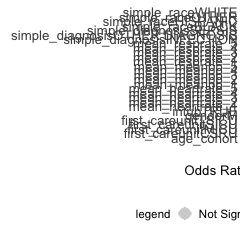

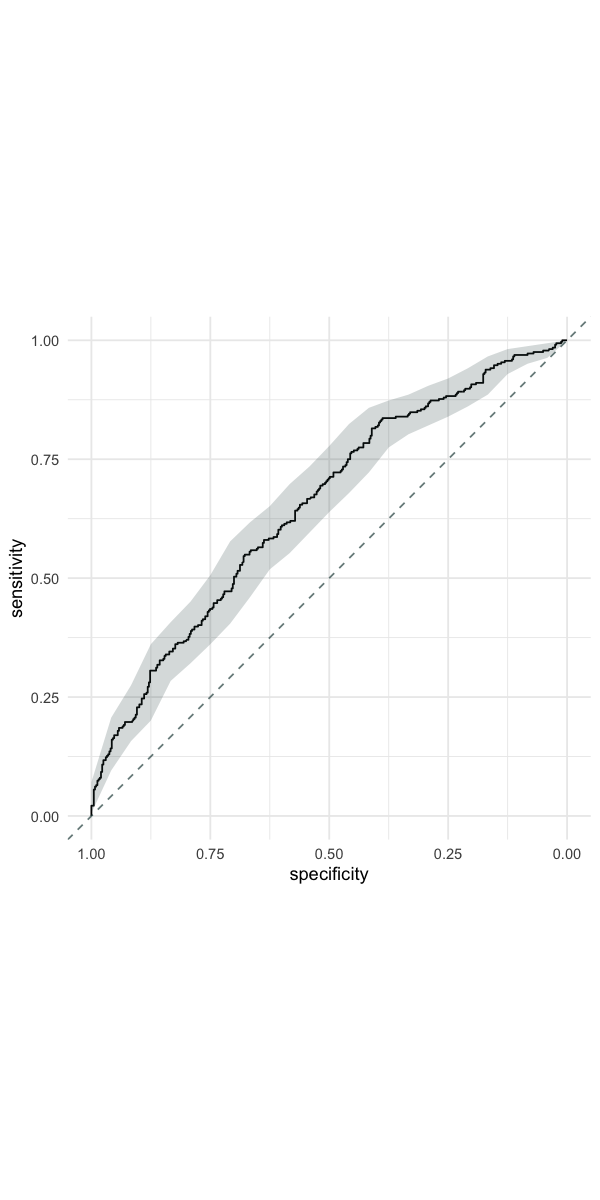

In [1159]:
for(pressor_choice in pressor_choices){
    cat(pressor_choice, "\n")
    
    model_input_df <- melt_results_df %>%
        filter(pressor == pressor_choice) %>%
        select(-pressor) %>%
        ungroup() %>%
        mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
        select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
        mutate(VALUE = as.character(VALUE)) %>%
        bind_rows(
            output_df %>% 
                filter(pressor == pressor_choice) %>%
                select(-pressor) %>%
                select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
                gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
                rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
                distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
        ) %>%
        drop_na(VALUE) %>%
        spread(VARIABLE, VALUE) %>% 
        select(-COURSE)

    model_input_df <- model_input_df %>%
        mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
        mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
        mutate(age_cohort = as.numeric(age_cohort)) %>%
        select(RESPONSE, 
                 first_careunit,
                 intub,
                 simple_diagnosis,
                 age_cohort,
                 gender,
                 contains("mean_meanbp"),
                 contains("mean_resprate"),
                 contains("mean_heartrate"),
                  )
    
    # devise the model
    model_input_df <- model_input_df[which(complete.cases(model_input_df)),]
    model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
    
    # isolate out model coefficients
    summary(model)$coefficients %>% data.frame() %>% 
        tibble::rownames_to_column("Variable") %>%
        rename(P.Value = Pr...z..) %>% 
        mutate(SIGNIFICANT = P.Value < 0.05) %>% 
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))
    
    # compute odds ratios from coefficients
    oddsratio <- exp(cbind(coef(model), confint(model)))
    
    # plot odds ratios
    options(repr.plot.height=10, repr.plot.width=5)
    p <- oddsratio %>% data.frame() %>%
        tibble::rownames_to_column("factor") %>%
        filter(factor != "(Intercept)") %>%
        rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
        rowwise() %>%
        mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
        mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
        ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
            base_theme()+
            theme(legend.position="bottom")+
            geom_pointrange(aes(col=legend))+
            scale_color_manual(values=SIGNIFICANT_COLORS)+
            geom_hline(yintercept =1, linetype=2, color = "firebrick")+
            xlab('')+ ylab("Odds Ratio (95% CI)")+
            geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
            coord_flip()
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelodds.pdf")), 5,10)
    plot(p)
    dev.off()
    
    # perform 5 fold CV
    options(repr.plot.width=3, repr.plot.height=3)
    input <- model_input_df
    k <- 5
    n <- dim(input)[1]
    indices <- sample(rep(1:k, ceiling(n/k))[1:n])

    all.acc <- all.response <- all.predictor <- aucs <- c()
    for (i in 1:k) {
      test = input[indices==i,]
      learn = input[indices!=i,]
      model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
      model.pred <- predict(model, newdata=test)
      model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
            summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
      aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
      all.response <- c(all.response, test$RESPONSE)
      all.predictor <- c(all.predictor, model.pred)
      all.acc <- c(all.acc, model.acc)
    }

    # compute ROC curves
    p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
    #plot(p_out, print.auc=TRUE)
    
    lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
    
    # plot ROC curve for pressor choices
    options(repr.plot.width=2, repr.plot.height=2)
    p <- roc_with_ci(p_out)

    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 2,2)
    plot(p)
    dev.off()

}

In [1216]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6710370,0.02599524,0.6780256,0.03778072
norepinephrinedurations,0.7321406,0.05208283,0.6616358,0.01223504
dopaminedurations,0.8578515,0.11483787,0.7961694,0.14423498
phenylephrinedurations,0.6816482,0.08261785,0.6983218,0.02551201


# LR Model for norepinephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [1199]:
pressor_choice <- 'norepinephrinedurations'

In [1187]:
model_input_df <- melt_results_df %>%
    filter(pressor == pressor_choice) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == pressor_choice) %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1197]:
# devise the model
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


Waiting for profiling to be done...


pdf 
  2

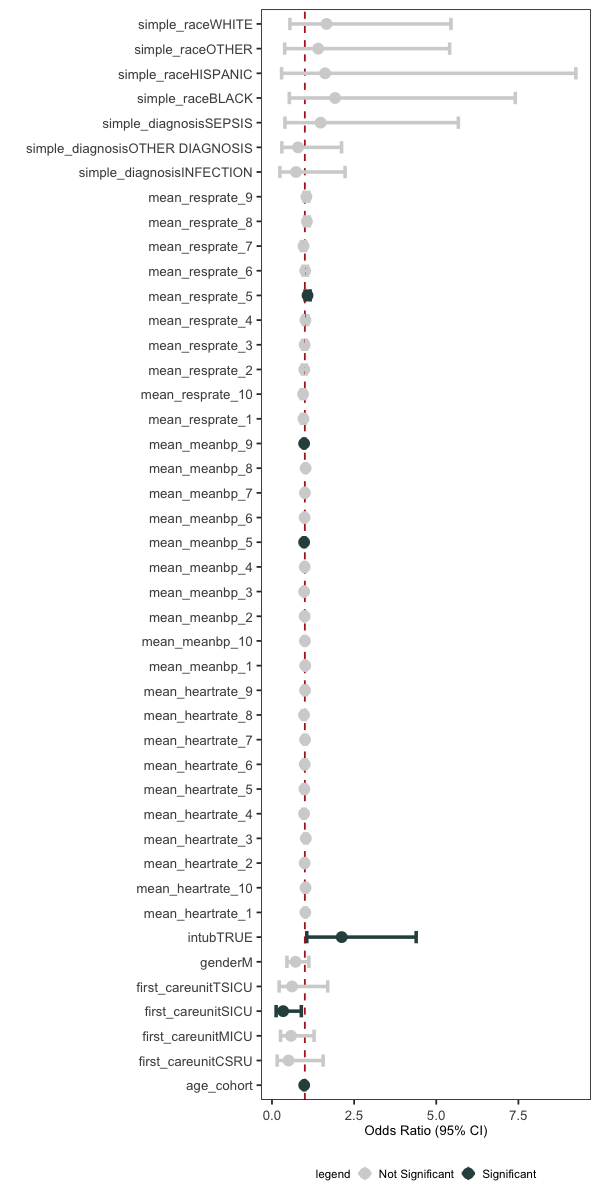

In [1198]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

# plot odds ratios
options(repr.plot.height=10, repr.plot.width=5)
p <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelodds.pdf")), 5,10)
plot(p)
dev.off()

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


pdf 
  2

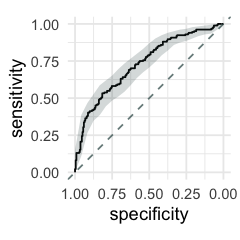

In [1200]:
# perform 5 fold CV
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])

all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

# compute ROC curves
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

# plot ROC curve for pressor choices
options(repr.plot.width=2, repr.plot.height=2)
p <- roc_with_ci(p_out)

plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 2,2)
plot(p)
dev.off()

In [1201]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                     SD_AUC = sd(aucs), 
                                     MEAN_ACC = mean(all.acc), 
                                     SD_ACC = sd(all.acc))

lr_summary_list[[pressor_choice]]

# LR Model for dopamine

In [1203]:
pressor_choice <- 'dopaminedurations'

In [1204]:
model_input_df <- melt_results_df %>%
    filter(pressor == pressor_choice) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == pressor_choice) %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1205]:
# devise the model
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fi

“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fi

Waiting for profiling to be done...
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities nume

“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fi

“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fi

pdf 
  2

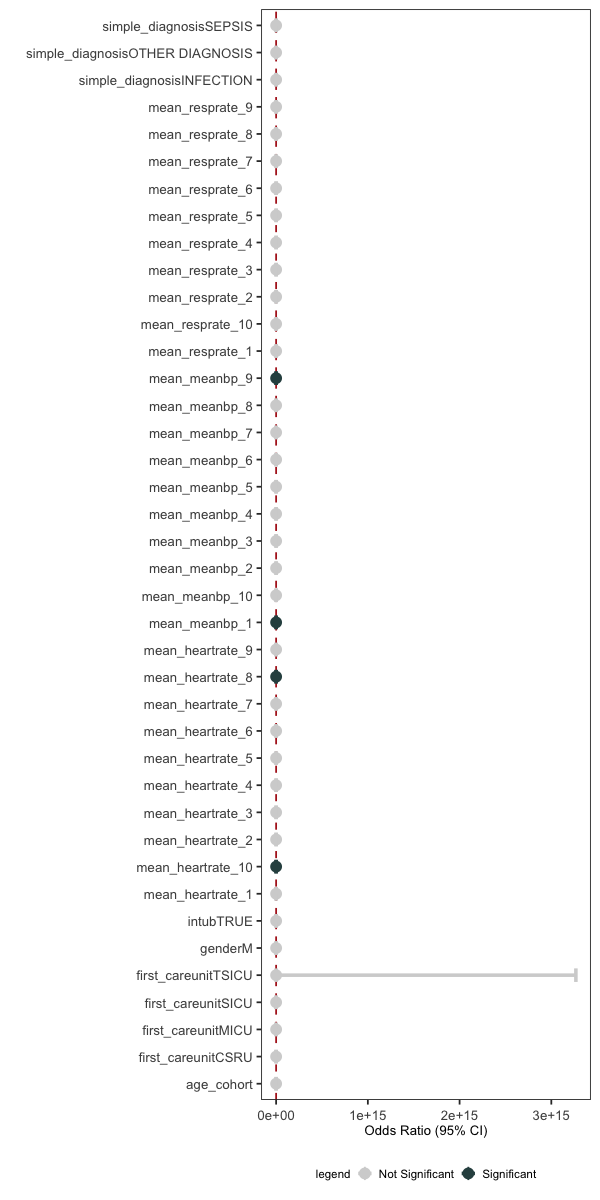

In [1206]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

# plot odds ratios
options(repr.plot.height=10, repr.plot.width=5)
p <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelodds.pdf")), 5,10)
plot(p)
dev.off()

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


pdf 
  2

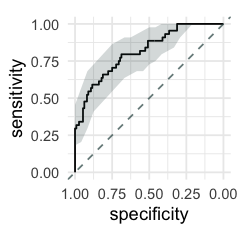

In [1207]:
# perform 5 fold CV
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])

all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

# compute ROC curves
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

# plot ROC curve for pressor choices
options(repr.plot.width=2, repr.plot.height=2)
p <- roc_with_ci(p_out)

plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 2,2)
plot(p)
dev.off()

In [1208]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                     SD_AUC = sd(aucs), 
                                     MEAN_ACC = mean(all.acc), 
                                     SD_ACC = sd(all.acc))

lr_summary_list[[pressor_choice]]

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.8578515,0.1148379,0.7961694,0.144235


# LR Model for Phenylephrine

In [1209]:
pressor_choice <- 'phenylephrinedurations'

In [1210]:
model_input_df <- melt_results_df %>%
    filter(pressor == pressor_choice) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == pressor_choice) %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1211]:
# devise the model
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


Waiting for profiling to be done...


pdf 
  2

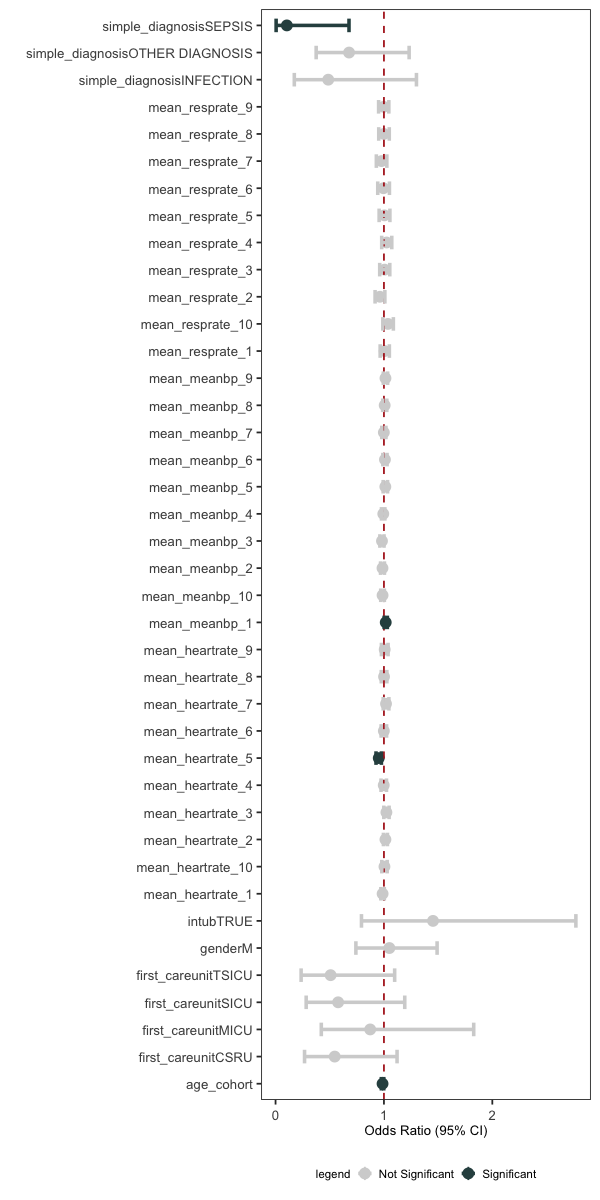

In [1212]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

# compute odds ratios from coefficients
oddsratio <- exp(cbind(coef(model), confint(model)))

# plot odds ratios
options(repr.plot.height=10, repr.plot.width=5)
p <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelodds.pdf")), 5,10)
plot(p)
dev.off()

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


pdf 
  2

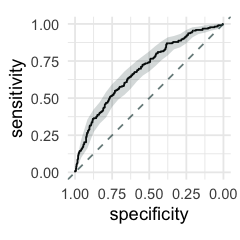

In [1213]:
# perform 5 fold CV
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])

all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

# compute ROC curves
p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

# plot ROC curve for pressor choices
options(repr.plot.width=2, repr.plot.height=2)
p <- roc_with_ci(p_out)

plot(p)

pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 2,2)
plot(p)
dev.off()

In [1214]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                     SD_AUC = sd(aucs), 
                                     MEAN_ACC = mean(all.acc), 
                                     SD_ACC = sd(all.acc))

lr_summary_list[[pressor_choice]]

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6816482,0.08261785,0.6983218,0.02551201


# Output AUC table

In [1217]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6710370,0.02599524,0.6780256,0.03778072
norepinephrinedurations,0.7321406,0.05208283,0.6616358,0.01223504
dopaminedurations,0.8578515,0.11483787,0.7961694,0.14423498
phenylephrinedurations,0.6816482,0.08261785,0.6983218,0.02551201


In [1219]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))